# AI project – Zucchetti Spa dataset

## Preprocessing

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

UNKNOWN = 'unknown'
SAMPLE = 10

In [177]:
# Read in the data from the CSV file into a a dataframe 
df = pd.read_csv('coded_log.csv', sep=";",names=['userId', '1?', 'date','eventType','application','2?','ip','3?','4?','5?'])

In [178]:
# Visualize a snippet of the data frame df
df.sample(SAMPLE)

,userId,1?,date,eventType,application,2?,ip,3?,4?,5?
289498,10258,573439978,2021-04-28 09:18:32.000,2,ERM,erm3zs02,ip_873,,,zulhqa7p64
235384,6356,995602748,2020-11-02 10:25:30.000,2,ERM,erm3zs02,ip_912,,,hr6d900fjq
542640,23042,461093977,2021-01-29 06:42:48.000,1,ERM,erm3zs02,ip_24157,001,kmlbuywdcs,tg8h2w5d8a
474568,20127,693818133,2021-04-14 08:39:26.000,1,HRW,NaN,NaN,001,zcagigfnmn,hgfe7azqjo
205249,3951,23252724,2020-06-24 09:05:24.000,1,HRC,NaN,NaN,001,,vulmlrfbr0
139943,2735,27912744,2021-04-28 13:47:46.000,1,ERM,erm3zs02,ip_1465,001,wdyylhaoec,xfvxati5g1
130441,2557,999995436,2020-02-07 21:35:05.000,1,HRC,NaN,NaN,001,,uwe50d39xe
548879,23177,926164894,2021-06-01 06:36:56.000,1,ERM,erm3zs02,ip_24908,001,xmnnqpcfdi,yk3p27dj85
230202,5069,239979916,2019-12-12 08:51:41.000,2,ERM,erm3zs02,ip_4017,,,a5kk907yzc
73292,1583,252519585,2021-06-22 11:49:14.000,1,ERM,erm3zs02,ip_1479,001,tewyzyrzem,zjh78rpqj7


In [179]:
#remove unkown coloums
df_ = df.drop(columns=['1?','2?','3?','4?','5?'])

df_.sample(SAMPLE)

,userId,date,eventType,application,ip
426246,18682,2021-02-03 06:57:29.000,1,ERM,ip_855
252187,9041,2020-01-07 11:33:35.000,1,ERM,ip_129
469338,20035,2021-04-22 15:42:15.000,1,ERM,ip_16813
536295,22702,2021-06-14 13:58:06.000,1,HRW,NaN
263662,9771,2021-06-04 17:21:47.000,1,ERM,ip_7864
232536,5654,2020-05-28 11:05:55.000,2,ERM,ip_5649
423532,18616,2021-04-20 19:00:10.000,1,ERM,ip_15961
78990,1686,2021-04-12 20:18:53.000,1,ERM,ip_1467
103413,2078,2021-06-23 18:18:31.000,1,ERM,ip_1469
806056,32562,2021-05-26 08:46:19.000,1,HR1,NaN


In [180]:
#cleaning row data

print('number of null entries:')
df_.isnull().sum()

number of null entries:


userId              0
date                0
eventType           0
application         0
ip             339741
dtype: int64

In [181]:
df_['ip'].fillna(UNKNOWN,inplace=True)

df_.sample(SAMPLE)

,userId,date,eventType,application,ip
60265,1310,2021-04-02 12:19:19.000,2,ERM,ip_1469
809145,32627,2021-05-04 10:08:39.000,1,HR1,unknown
256072,9306,2019-12-15 17:34:34.000,1,ERM,ip_7782
566952,23587,2021-06-07 13:01:11.000,1,ERM,ip_26187
453064,19767,2021-06-03 17:14:45.000,1,ERM,ip_15222
15292,195,2021-04-09 16:56:50.000,1,HR1,unknown
687307,27840,2021-05-07 08:37:01.000,1,ERM,ip_1099
61438,1337,2021-04-20 11:24:25.000,1,ERM,ip_1465
689585,27879,2021-03-23 22:33:55.000,2,ERM,ip_6100
39588,886,2020-03-31 16:43:43.000,2,ERM,ip_555


### Data cleaning

In [182]:
df_['date'] = pd.to_datetime(df_['date'], format="%Y-%m-%d %H:%M:%S.%f")

# sorting by date and userId
df_.sort_values(by=["userId", "date"],ascending=(True, True),inplace=True)

#check data consistency: delete rows containing non-valid event code
df_ = df_[(df_.eventType >= 1) & (df_.eventType <= 3)]

#check data rendundancy
duplicates = df_.duplicated().sum()
if(duplicates > 0):
    print(f'Duplicates number {duplicates} on {len(df_.index)}')
    df_.drop_duplicates(inplace = True)
    print(f'New size:{len(df_.index)}')
df_

Duplicates number 3432 on 849552
New size:846120


,userId,date,eventType,application,ip
9162,1,2021-03-22 20:03:59,1,HRW,unknown
5482,1,2021-03-22 20:18:59,1,HRW,unknown
1872,1,2021-03-22 20:33:59,1,HRW,unknown
8919,1,2021-03-22 20:48:59,1,HRW,unknown
3704,1,2021-03-22 21:03:59,1,HRW,unknown
...,...,...,...,...,...
849547,33952,2021-06-23 08:45:56,1,ERM,ip_780
849548,33953,2021-06-23 08:07:16,1,ERM,ip_15260
849549,33954,2021-06-23 10:18:33,1,ERM,ip_15260
849550,33961,2021-06-24 08:58:23,1,ERM,ip_124


In [183]:
# counting unique values
userIdNumber = len(pd.unique(df_['userId']))

print(f'**** Within the dataset there are {userIdNumber} users ****')

**** Within the dataset there are 18080 users ****


In [184]:
print('##########################################')
print(f"{df_.groupby('eventType').eventType.count()}")
print('##########################################')

##########################################
eventType
1    628356
2     92058
3    125706
Name: eventType, dtype: int64
##########################################


### Utility functions

#### Constants

In [186]:
#working hours boundary
START_WORKING = 8
END_WORKING = 19
#time boundaries for series construction
AT_LEAST_ONE_DAY = 24 * 3600 * 1000 # 24 h
MAX_DELAY_ERRORS = 5 * 60 * 1000 # 5min
MAX_DELAY_SUCCESS = 5 * 60 * 1000 # 5min
#attempts boundaries
MAX_ATTEMPTS = 3
MAX_TIME_BOT = 5000 # maximum time for a bot to insert a password. We consider users emulation and special chars

#events type
FAILED_LOGIN = 2
SUCCESSFUL_LOGIN = 1
LOGOUT = 3

#weights
WORKINGTIME_WORKINGDAY = 0.25
NOT_WORKINGTIME_WEEKDAY = 0.35
WORKINGTIME_NOT_WORKINGDAY = 0.45
NOT_WORKINGTIME_NOT_WEEKDAY = 0.55

#### Weigthin function

In [185]:


def suspicious(serie):
    """
    serie[0] = "userId"
    serie[1] = "avgTime"
    serie[2] = "failedAttempts"
    serie[3] = "hasSuccess"
    serie[4] = "application"
    serie[5] = "workingTime"
    serie[6] = "day"
    serie[7] = "ipAmount"
    serie[8] = "suspicious"
    """
    
    # weights
    timeW = timeWeight(serie[6], serie[5])
    ipAmount = (1/(serie[7])) if serie[7] > 1 else 0.6 #one ip used case 
    serieW = serieWeight(serie[1], serie[2], serie[3])
    failedAttempts = 1- (1/serie[2])
    return graham([timeW,ipAmount,serieW])#((5 * timeW) + (25 * ipAmount) + (70 * serieW))/100 # percentage

#graham formula to avoid underflow 
def graham(weights:list):
    mu = 0
    for w in weights:
        mu += np.log(1 - w) - np.log(w)
    return 1/(1+np.e**mu)

def timeWeight(day, isWorkingTime):
    weekDay = day in range(1,6)
    if isWorkingTime and weekDay:
        w = WORKINGTIME_WORKINGDAY
    elif not isWorkingTime and weekDay:
        w = NOT_WORKINGTIME_WEEKDAY
    elif isWorkingTime and not weekDay:
        w = WORKINGTIME_NOT_WORKINGDAY
    elif not isWorkingTime and not weekDay:
        w = NOT_WORKINGTIME_NOT_WEEKDAY
    return w


def serieWeight(avgTime, failedAttempts, hasSuccess):
    w = 0
    timeLargerThanBot = avgTime > MAX_TIME_BOT
    trialsLessThanMax = failedAttempts <= MAX_ATTEMPTS
    if hasSuccess:
        if failedAttempts == 1:
            w = 0.01 if timeLargerThanBot else 0.1   
        elif trialsLessThanMax:
            w = 0.1 if timeLargerThanBot else 0.65
        else:
            w = getWeight(avgTime,failedAttempts)
    else:
        if failedAttempts == 1:
            w = 0.01 if timeLargerThanBot else 0.1
        elif trialsLessThanMax:
            w = 0.5 if timeLargerThanBot else 0.9
        else:
            w = getWeight(avgTime,failedAttempts)
    return w

def getWeight(avgTime,failedAttempts):
    human = avgTime > MAX_TIME_BOT
    bot = np.cos(failedAttempts/avgTime)
    w = 0
    if human:
        if(failedAttempts < 9):
            w = 0.8
        else:
            w = 0.95
    else:
        w = bot
    return w


## Dataframe login construction

#### Lambda functions

In [187]:
# deterimine if the log was dueing working hours
isWorkingTime = lambda x: 1 if (x.isoweekday() in range(1,6) and x.to_pydatetime().hour >= START_WORKING and x.to_pydatetime().hour <= END_WORKING) else 0

# toDay: convert a stirng representing a date into a number 
#    1 --> Monday
#    2 --> Tuesday
#    ...
#    7 --> Sunday
toDay = lambda x: x.isoweekday() 

In [188]:
#setting up the 1st datase
df_logins = pd.DataFrame(columns=['userId', 'date', 'day', 'workingTime', 'eventType', 'application',"ip"])
df_logins['userId'] = df_['userId']
df_logins['date'] = df_["date"]
df_logins['day'] = df_logins['date'].apply(toDay)
df_logins['workingTime'] = df_logins['date'].apply(isWorkingTime)
df_logins['eventType'] = df_['eventType']
df_logins['application'] = df_['application']
df_logins['ip'] = df_['ip']

#df_logins.drop(columns=['date'], inplace=True)
df_logins.head(SAMPLE)

,userId,date,day,workingTime,eventType,application,ip
9162,1,2021-03-22 20:03:59,1,0,1,HRW,unknown
5482,1,2021-03-22 20:18:59,1,0,1,HRW,unknown
1872,1,2021-03-22 20:33:59,1,0,1,HRW,unknown
8919,1,2021-03-22 20:48:59,1,0,1,HRW,unknown
3704,1,2021-03-22 21:03:59,1,0,1,HRW,unknown
4120,1,2021-03-22 21:18:59,1,0,1,HRW,unknown
9001,1,2021-03-22 21:33:59,1,0,1,HRW,unknown
6135,1,2021-03-22 21:48:59,1,0,1,HRW,unknown
8505,1,2021-03-22 22:03:59,1,0,1,HRW,unknown
4633,1,2021-03-22 22:18:59,1,0,1,HRW,unknown


#### Data plotting

Every log between Friday and Sunday occurred outside working time 

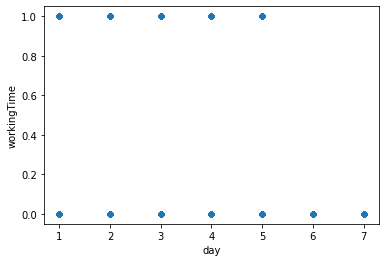

In [189]:
df_logins.plot(x = 'day', y = 'workingTime', kind = 'scatter')
plt.show()

Each kind of event is happend in both working time and non-working time

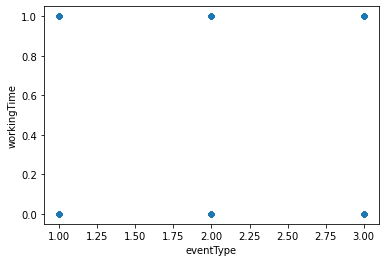

In [190]:
df_logins.plot(x = 'eventType', y = 'workingTime', kind = 'scatter')
plt.show()

Failed logins attempts occurred only for application ERM, HRW and TM3 

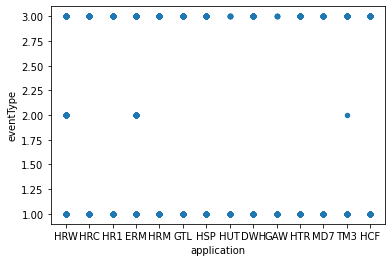

In [191]:
df_logins.plot(x = 'application', y = 'eventType', kind = 'scatter')
plt.show()

In [192]:
#remove attemps regarding applications with no errors associated
df_logins.drop(df_logins[df_logins["application"].isin(["ERM","HRW","TM3"]) == False].index ,inplace=True)
np.unique(df_logins["application"])

array(['ERM', 'HRW', 'TM3'], dtype=object)

### Series dataframe construction

In [193]:
# group by the userId
df_groupbyUserId = df_logins.groupby('userId')

In [194]:
# Retrieving users id
users_id = []
for key, value in df_groupbyUserId:
    users_id.append(key)

# Take userId having 0 or 1 login errors
userList = []

for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    ctr = user_group[user_group["eventType"] == FAILED_LOGIN].count()
    if ctr["eventType"] <= 1:
        userList.append(i)

In [195]:
# remove from the dataset all the users in userList
df_logins = df_logins[df_logins["userId"].isin(userList) == False]
df_logins.sample(SAMPLE)

,userId,date,day,workingTime,eventType,application,ip
784747,32018,2021-03-25 12:00:33,4,1,1,ERM,ip_15555
822581,33011,2021-02-06 11:01:56,6,0,2,ERM,ip_43471
776616,31835,2021-05-27 16:40:36,4,1,1,ERM,ip_15279
843212,33349,2021-05-13 14:32:58,4,1,1,ERM,ip_124
338015,13305,2020-12-30 13:01:48,3,1,1,ERM,ip_126
302884,11849,2021-04-01 11:41:17,4,1,2,ERM,ip_114
404466,17492,2020-12-16 11:57:31,3,1,1,ERM,ip_14716
578125,24030,2021-04-15 15:02:42,4,1,2,ERM,ip_1099
731656,29351,2021-05-13 09:20:24,4,1,1,ERM,ip_126
32977,663,2021-06-28 08:39:37,1,1,1,ERM,ip_781


In [196]:
df_groupbyUserId = df_logins.groupby('userId')

In [197]:
# list of remaining userId 
users_id = [user for user in users_id if (user not in userList)]

userList.clear()

# getting all users having at least two login errors
for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    rowsNumber = len(user_group.index)
    j = 0
    while j < rowsNumber - 1:
        if user_group.iloc[j]["eventType"] == FAILED_LOGIN:
            k = j+1            
            while k < rowsNumber and user_group.iloc[k]["eventType"] != FAILED_LOGIN:
                k += 1
            if k == 1 or k != rowsNumber: # after a login error the user have other login errors (1 or more)
                userList.append(i)
                break
            j = k
        else:
            j += 1

In [198]:
# remove all users having only successful attempts after an error
df_logins = df_logins[df_logins["userId"].isin(userList)]
df_logins.sample(SAMPLE)

,userId,date,day,workingTime,eventType,application,ip
535742,22662,2021-05-05 17:26:35,3,1,1,ERM,ip_14514
303449,11938,2021-04-19 14:41:53,1,1,2,ERM,ip_114
82290,1766,2021-05-11 14:03:30,2,1,1,ERM,ip_1469
28934,531,2021-06-24 08:07:47,4,1,1,ERM,ip_572
334240,13289,2021-04-12 17:38:04,1,1,1,ERM,ip_12337
616112,25356,2021-04-23 11:32:49,5,1,1,HRW,unknown
625684,25677,2021-03-30 13:05:07,2,1,1,ERM,ip_1465
510271,21493,2021-04-21 18:45:02,3,1,1,ERM,ip_916
803203,32480,2021-01-08 12:56:48,5,1,2,ERM,ip_30440
825133,33062,2021-06-16 19:16:08,3,1,3,TM3,unknown


In [199]:
df_groupbyUserId = df_logins.groupby('userId')

In [200]:
# list of remaining userId
users_id = [user for user in users_id if (user in userList)]

userList = []

# take all users who have at least 2 login errors in 24h
for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    rowsNumber = len(user_group.index)
    j = 0
    while j < rowsNumber - 1:
        if user_group.iloc[j]["eventType"] == FAILED_LOGIN:
            k = j+1          
            while k < rowsNumber and user_group.iloc[k]["eventType"] != FAILED_LOGIN:
                k += 1
            if k == 1 or k != rowsNumber:
                delta = (user_group.iloc[k]["date"] - user_group.iloc[j]["date"]).total_seconds() * 1000
                if delta < AT_LEAST_ONE_DAY:
                    userList.append(i) # save userId
                    break
            j = k
        else:
            j += 1


In [201]:
# remove all users who do not have 2 login errors in 24h
df_logins = df_logins[df_logins["userId"].isin(userList)]
df_logins

,userId,date,day,workingTime,eventType,application,ip
9684,17,2021-02-02 09:04:05,2,1,2,ERM,ip_4
9685,17,2021-02-02 09:04:05,2,1,1,ERM,ip_4
9692,17,2021-03-04 10:30:15,4,1,2,ERM,ip_4
9694,17,2021-03-04 10:30:15,4,1,1,ERM,ip_4
9698,17,2021-03-04 10:30:22,4,1,2,ERM,ip_4
...,...,...,...,...,...,...,...
849533,33949,2021-06-28 15:11:01,1,1,2,ERM,ip_1285
849532,33949,2021-06-28 15:17:00,1,1,2,ERM,ip_1285
849531,33949,2021-06-28 15:17:22,1,1,2,ERM,ip_1285
849535,33949,2021-06-28 15:20:47,1,1,2,ERM,ip_1285


In [202]:
df_groupbyUserId = df_logins.groupby('userId')

In [203]:
# find sequences of login errors


# serie entry: (date, eventType, application, workingTime, day, ip if userMode else userId)
def buildCouple(group,i,userMode):
    return (group.iloc[i]["date"],group.iloc[i]["eventType"],
            group.iloc[i]["application"],group.iloc[i]["workingTime"],
            group.iloc[i]["day"],group.iloc[i]["ip"] if userMode else group.iloc[i]["userId"])

# store serie into dictionary
def saveSerie(user_idex,record_index,serie,storage):
    failureSeries = storage[user_idex]
    failureSeries.append(serie)
    storage[user_idex] = failureSeries

# find series of login errors for each user considering each application which has failed attempts
def findSeries(subjects,df_groupBySubject,storage,userMode):
    for i in subjects: # for each user
        subject_group = df_groupBySubject.get_group(i) # get login attempts for the user
        rowsNumber = len(subject_group.index) # get number of logins attempts
        storage[i] = [] # initialize user's value into dictionary
        for app in ["ERM", "HRW", "TM3"]: # for each app
            serie = [] # initializing empty serie
            j = 0
            while(j < rowsNumber): # for each login attempt
                # if the attempt is an error for the current app
                if(subject_group.iloc[j]["eventType"] == FAILED_LOGIN and subject_group.iloc[j]["application"] == app):
                    serie.append(buildCouple(subject_group,j,userMode)) # append the first attempt to the serie
                    k = j + 1
                    loginSuccess = False
                    eventFailure = False
                    while(k < (rowsNumber - 1) and not eventFailure and not loginSuccess): # searching for the next attempt
                        # if the attempt is successful
                        if (subject_group.iloc[k]["eventType"] == SUCCESSFUL_LOGIN and subject_group.iloc[k]["application"] == app): # login eseguito correttamente dopo un fallimento
                            loginSuccess = True
                        # else, if the attempt is an error
                        elif (subject_group.iloc[k]["eventType"] == FAILED_LOGIN and subject_group.iloc[k]["application"] == app):
                             eventFailure = True
                        k += 1

                    # for both event type
                    if(eventFailure or loginSuccess):
                        # compute the time intervall in milliseconds between the two attempts
                        delta = (subject_group.iloc[k]["date"] - subject_group.iloc[j]["date"]).total_seconds() * 1000

                        # in case the current failed attempt occurs in MAX_DELAY_ERRORS
                        if eventFailure and delta < MAX_DELAY_ERRORS:
                            serie.append(buildCouple(subject_group,k-1,userMode)) # append to the current serie
                        # else
                        elif eventFailure and not delta < MAX_DELAY_ERRORS:
                            saveSerie(user_idex=i,record_index=k-1,serie=serie,storage=storage) # save the current serie
                            serie = [] # starting a new serie
                            serie.append(buildCouple(subject_group,k-1,userMode)) # append the attempt
                        # in case the current successful attempt occur in MAX_DELAY_SUCCESS
                        elif loginSuccess and delta < MAX_DELAY_SUCCESS:
                            serie.append(buildCouple(subject_group,k-1,userMode)) # append it to the current serie for closing it
                            saveSerie(user_idex=i,record_index=k-1,serie=serie,storage=storage) # save the serie
                            serie = [] # starting a new serie
                        # else
                        elif loginSuccess and not delta < MAX_DELAY_SUCCESS:
                            saveSerie(user_idex=i,record_index=k-1,serie=serie,storage=storage) # save the serie
                            serie = [] # starting a new one
                    j = k

                # in case there is an open serie, it is closed
                # if successful attempt is found for the same application
                elif(len(serie) > 0 and subject_group.iloc[k]["application"] == serie[len(serie) - 1][2]): 
                    # check delay
                    delta = (subject_group.iloc[k]["date"] - serie[len(serie) - 1][0]).total_seconds() * 1000
                    if(delta <  MAX_DELAY_SUCCESS):
                        serie.append(buildCouple(subject_group,j,userMode))
                    saveSerie(user_idex=i,record_index=j,serie=serie,storage=storage)
                    serie = []
                    j += 1
                else:
                    j += 1

            # when attempts are over, save the serie
            if(len(serie) > 0):
                saveSerie(user_idex=i,record_index=j,serie=serie,storage=storage)
                serie = [] 

In [204]:
#BUILDING USERS SERIES
"""
key: userId
value: list of failed attempts series
"""
failedAttemptsSeries = dict()
findSeries(subjects=userList,df_groupBySubject=df_groupbyUserId,storage=failedAttemptsSeries,userMode=True)
failedAttemptsSeries[238]

[[(Timestamp('2021-05-04 11:33:51'), 2, 'ERM', 1, 2, 'ip_219'),
  (Timestamp('2021-05-04 11:34:27'), 2, 'ERM', 1, 2, 'ip_219'),
  (Timestamp('2021-05-04 11:36:03'), 1, 'ERM', 1, 2, 'ip_219')],
 [(Timestamp('2021-05-25 18:39:07'), 2, 'ERM', 1, 2, 'ip_221'),
  (Timestamp('2021-05-25 18:39:21'), 1, 'ERM', 1, 2, 'ip_221')]]

#### Computing metrics

In [205]:
# compute metrics for a serie
def computeMetrics(seriesStorage):
    seriesEvalIndex = [] # 
    for k in seriesStorage.keys():
        series = seriesStorage[k]
        #(userId,tempoMedio, tentativiFalliti, hasSuccess, applicazione)
        for serie in series:
            length = len(serie)
            i = 0
            delta = 0
            hasSuccess = False
            amount_item_set = set()
            amount_item_set.add(serie[0][-1]) #numero di indirizzi ip usati o numero di ip
            workingTime = 1
            while(i < length - 1):
                delta += (serie[i+1][0] - serie[i][0]).total_seconds() * 1000
                amount_item_set.add(serie[i][-1])
                workingTime &= serie[i][3]
                i += 1
            hasSuccess = serie[-1][1] == 1
            t = (k, int(delta/(length-1 if length > 1 else length )) ,length - 1 if hasSuccess else length,1 if hasSuccess else 0,
                 serie[0][2],workingTime,serie[i][4],len(amount_item_set))
            seriesEvalIndex.append(t)
    return seriesEvalIndex

#### User series dataframe

In [206]:
#building users series dataframe 
seriesEvalIndex = computeMetrics(failedAttemptsSeries)
df_series = pd.DataFrame(seriesEvalIndex,columns=["userId","avgTime","failedAttempts","hasSuccess","application","workingTime","day","ipAmount"])
#delete series with just one log err and so average mean equal to 0
df_series.drop(df_series[ df_series["avgTime"] == 0 ].index,inplace=True)
df_series
df_series.sample(SAMPLE)

,userId,avgTime,failedAttempts,hasSuccess,application,workingTime,day,ipAmount
6680,3890,12000,1,1,ERM,0,4,1
40892,33456,47500,5,0,ERM,1,4,1
17963,16929,27000,2,0,ERM,1,2,1
2424,1559,19000,1,1,ERM,1,3,1
27702,25140,497000,2,0,ERM,1,5,1
37857,32175,49666,4,0,ERM,0,3,1
27061,24597,2205000,3,0,ERM,1,2,1
26877,24431,241268000,2,0,ERM,1,6,1
33353,28973,57500,2,1,ERM,0,2,1
31121,27582,33000,2,0,ERM,1,3,1


### Weighting functions interval for user series

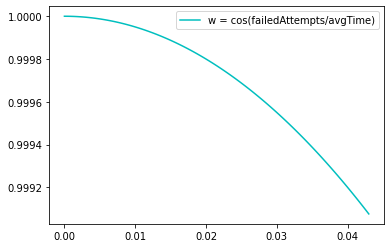

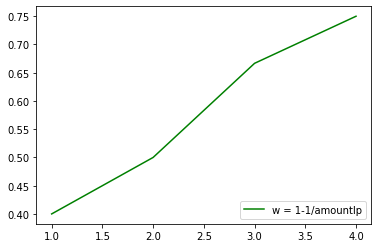

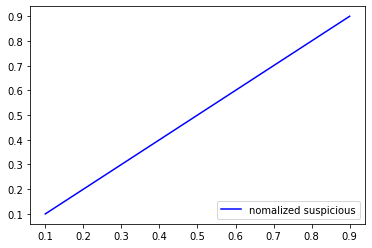

In [229]:
# plotting weigth assign to bot according to attemps average time and failed attempts number 
max_ratio = df_series["failedAttempts"].max()/df_series["avgTime"].min()
min_ratio = df_series["failedAttempts"].min()/df_series["avgTime"].max()
x = np.linspace(min_ratio,max_ratio,100)
y = np.cos(x)
plt.plot(x,y,'c',label="w = cos(failedAttempts/avgTime)")
plt.title = "Weight for BOT"
plt.legend(loc='upper right')
plt.show()
# plotting weigth releated to ip used within a serie
max_ip_number = df_series["ipAmount"].max()
min_ip_number = df_series["ipAmount"].min()
y =[]
x = range(min_ip_number,max_ip_number+1)
for amount in x:
    y.append(1 - (1/amount if amount > 1 else 0.6))
plt.title = "Weight for ipAmount"
plt.plot(x,y,'g',label="w = 1-1/amountIp")
plt.legend(loc='lower right')
plt.show()
y = []
for i in np.arange(0.1,1.0,0.1):
    y.append(graham([i]))
x = np.arange(0.1,1.0,0.1)
plt.title = "Graham function"
plt.plot(x,y,'b',label="nomalized suspicious")
plt.legend(loc='lower right')
plt.show()

In [208]:
df_series['suspicious'] = df_series.apply(lambda row : suspicious(row), axis=1)

In [209]:
df_series[df_series["suspicious"] == df_series["suspicious"].max()]

,userId,avgTime,failedAttempts,hasSuccess,application,workingTime,day,ipAmount,suspicious
24280,22215,3333,4,0,ERM,1,3,1,0.999999


In [210]:
#df_series[df_series["failedAttempts"] == df_series["failedAttempts"].max()]

In [212]:
df_series[(df_series["avgTime"] < 5000) & (df_series["failedAttempts"] > 3)].sort_values(by=['suspicious'])

,userId,avgTime,failedAttempts,hasSuccess,application,workingTime,day,ipAmount,suspicious
10159,6229,1000,4,0,ERM,1,2,1,0.999984
30077,26694,2666,4,0,HRW,1,3,1,0.999998
24263,22215,3500,5,0,ERM,1,3,1,0.999998
35397,31002,4000,10,0,ERM,0,6,1,0.999998
24280,22215,3333,4,0,ERM,1,3,1,0.999999


In [213]:
byApp = df_series[df_series["suspicious"] > 0.5].groupby(by=["application"])
tmp = byApp.userId.count()
tmp

application
ERM    5769
HRW       7
Name: userId, dtype: int64

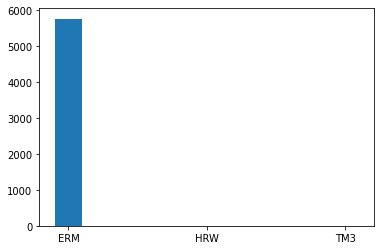

In [214]:
x = [k for k in tmp.keys()]
x.append("TM3")
y = [tmp[k] for k in tmp.keys()]
y.append(0)

plt.bar(x,y,width=0.2)
plt.title = "Most suspicious applcation"
plt.show()

From the graph we can say that in optics of cyber attacks it is not meaningful to be based on the working time  and day of the week, as we have suspicious series regardless of the parameters related to these factors.

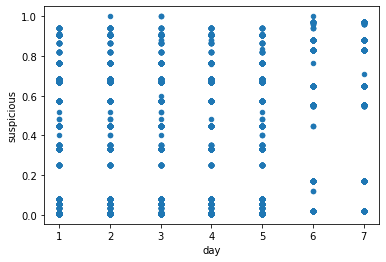

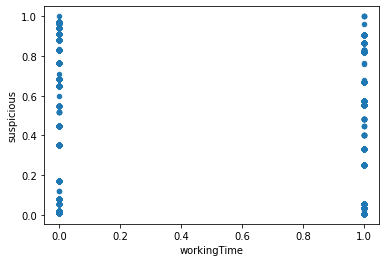

In [230]:
df_series.plot(x = 'day', y = 'suspicious', kind = 'scatter')
plt.show()
df_series.plot(x = 'workingTime', y = 'suspicious', kind = 'scatter')
plt.show()

Comparing amount of ip and failed attempts we can notice that with a single ip the number of failed attempts is bigger.
_It may indicate a presence of a target of an attack_. 
**Possible scenario**: attackers know the username of an employee and do they try guessing the password. 

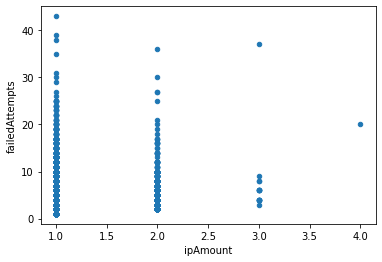

In [234]:
df_series.plot(x = 'ipAmount', y = 'failedAttempts', kind = 'scatter')
plt.show()

When the series of login attempts is closed with a successful attempts, the number of failed attempts is approximately the half respect to the complementary case.

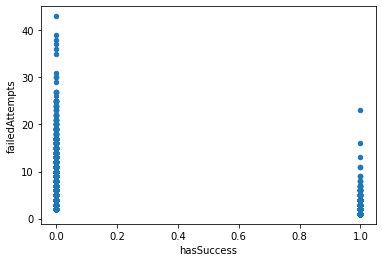

In [240]:
df_series.plot(x = 'hasSuccess', y = 'failedAttempts', kind = 'scatter')
plt.show()

The average time between login attempts and number of failures are inversely proportional. Indeed _suspicious_ assumes values close to one when the average time gets shorter (the number of failed attempts gets larger).

10231           1
9794            1
22362           1
19885           1
19965           1
           ...   
8694     39376180
9026     40603545
11392    41297953
10271    47257494
30523    47526107
Name: avgTime, Length: 29352, dtype: int64

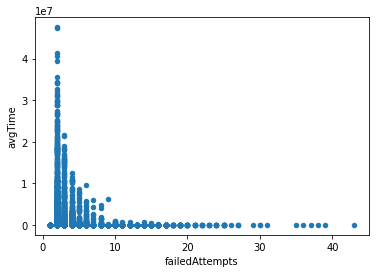

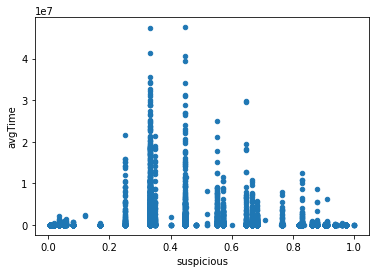

In [264]:
df_tmp = df_series.copy()
df_tmp["avgTime"] = df_tmp["avgTime"].apply(lambda x: int(x/1000))
df_tmp.plot(y="avgTime",x="failedAttempts",kind="scatter")
df_tmp.plot(y="avgTime",x="suspicious",kind="scatter")
df_tmp["avgTime"].sort_values()

## IP series analysis

In [219]:
failedAttemptsSeriesIP = dict()
df_logins.sort_values(by=["ip","date"],ascending=(True, True),inplace=True)
df_groupBy_ip = df_logins.groupby(by=["ip"])
df_groupBy_ip
ips = np.unique(df_logins["ip"])
findSeries(subjects=ips,df_groupBySubject=df_groupBy_ip,storage=failedAttemptsSeriesIP,userMode=False)
#failedAttemptsSeriesIP

In [220]:
#computing metics
seriesEvalIndex = computeMetrics(failedAttemptsSeriesIP)
df_ip_series = pd.DataFrame(seriesEvalIndex,columns=["ip","avgTime","failedAttempts","hasSuccess","application","workingTime","day","userAmount"])
#delete series with just one log err and average mean equal to 0
df_ip_series.drop(df_ip_series[ df_ip_series["avgTime"] == 0 ].index,inplace=True)
df_ip_series['suspicious'] = df_ip_series.apply(lambda row : suspicious(row), axis=1)
df_ip_series[df_ip_series["suspicious"] == df_ip_series["suspicious"].max()]

,ip,avgTime,failedAttempts,hasSuccess,application,workingTime,day,userAmount,suspicious
19671,ip_21607,3500,5,0,ERM,1,3,1,0.999998


In [236]:
df_ip_series[df_ip_series["userAmount"] == df_ip_series["userAmount"].max()]

,ip,avgTime,failedAttempts,hasSuccess,application,workingTime,day,userAmount,suspicious
39331,ip_855,60789,20,0,ERM,1,1,13,0.345455


### Users dataframe construction

In [221]:
byUserId = df_series.groupby(by=["userId"])
meanSuspicous = byUserId["suspicious"].mean()
meanSuspicous

userId
18       0.666667
21       0.052632
24       0.092369
33       0.052632
35       0.024068
           ...   
33899    0.052632
33920    0.500000
33928    0.035714
33934    0.446809
33949    0.634921
Name: suspicious, Length: 8718, dtype: float64

In [222]:
seriesNumber = byUserId["suspicious"].count()
seriesNumber

userId
18       1
21       1
24       6
33       1
35       5
        ..
33899    1
33920    2
33928    1
33934    1
33949    3
Name: suspicious, Length: 8718, dtype: int64

In [223]:
users = []
for key, value in byUserId:
    users.append(key)

df_users = pd.DataFrame(columns=["userId","isSuspicious"])

df_users["userId"] = users
df_users["isSuspicious"] = meanSuspicous.values
df_users["seriesNumber"] = seriesNumber.values
df_users.sample(SAMPLE)

,userId,isSuspicious,seriesNumber
5436,22817,0.005025,2
6680,27130,0.333333,1
4730,20416,0.052632,1
720,2187,0.052632,1
3990,17617,0.333333,1
6649,26991,0.733802,5
302,1081,0.036259,4
8251,32339,0.130330,3
8055,31892,0.005025,1
4512,19846,0.005025,1


In [224]:
df_users[df_users["isSuspicious"] == df_users["isSuspicious"].max()]

,userId,isSuspicious,seriesNumber
4719,20392,0.972093,1
4831,20686,0.972093,1
4849,20749,0.972093,1


#### Plotting

suspicious --> range [0,1]
- 0 se non è un login sospetto
- 1 se è certo al 100% che il login è sospetto

Pesi:
- XXXXXX 1/avgBtw2loginErr                       --> tempo fra login errati minore di soglia
- XXXXXX 1/f(day & isWorkingTime) 
- XXXXXX 1 - (1/numeroIpUsati)                         --> login di errore eseguiti da ip diversi
- se ha login con successo --> vedo quanti tentativi ha fatto: 
    - se il numero di tentativi è <= 3 e il tempo è > del tempoBot --> assegno valore grande (0.1)
    - se il # tentativi <= 3 e il tempo è < del tempoBot --> assegno valore piccolo (0.7) (password corretta)
    - se il # tentativi > 3:
        - tempo > tempoBot --> 0.2 (utente stupido O collega che cerca di entrare)
        - tempo <= tempoBot --> 1.0 (bot entrato)
- altrimenti --> guardo il numero di tentativi:
    - <= 3 & tempo > tempoBot --> 0.3 (user ha dimenticato password)
    - <= 3 & tempo <= tempoBot --> 0.9 (bot cerca di entrare ma smette la ricerca presto)
    - > 3 & tempo > tempoBot --> 0.4 (user ha dimenticato password e cerca di entrare troppe volte)
    - > 3 & tempo < tempoBot --> 1.0 (bot cerca di entrare tante volte)


**suspicious = w1 * w2 * ... * wn**


<br>
<br>


Step process:
- valutare range variabiltà pesi
- analisi per group by IP
- mettere costanti per i pesi
- commentare parti restanti
